In [61]:
import pandas as pd
import sqlite3

# Veritabanına bağlan
conn = sqlite3.connect("papcorns.sqlite")

# users ve user_events tablolarını oku
users_df = pd.read_sql("SELECT * FROM users", conn)
events_df = pd.read_sql("SELECT * FROM user_events", conn)

# Tarihleri dönüştür
users_df["created_at"] = pd.to_datetime(users_df["created_at"])
events_df["created_at"] = pd.to_datetime(events_df["created_at"])
events_df["amount_usd"] = pd.to_numeric(events_df["amount_usd"], errors="coerce")

# Kullanıcı başına özet istatistik çıkarımı
def extract_features(events):
    event_counts = events.pivot_table(index="user_id", columns="event_name", aggfunc="size", fill_value=0)
    payments = events.groupby("user_id")["amount_usd"].sum().rename("total_payment")
    active_days = events.groupby("user_id").agg(first_event=("created_at", "min"),
                                                last_event=("created_at", "max"))
    active_days["active_days"] = (active_days["last_event"] - active_days["first_event"]).dt.days
    churned = events.groupby("user_id")["event_name"].apply(lambda x: int("subscription_cancelled" in x.values))

    features = event_counts.join([payments, active_days["active_days"], churned.rename("churned")])
    return features.reset_index()

# Özellikleri çıkar
user_features = extract_features(events_df)

# Kullanıcı bilgileri ile birleştir
combined_df = user_features.merge(users_df, left_on="user_id", right_on="id").drop(columns=["id", "name", "created_at"])

# Kategorik değişkenleri one-hot encode et
final_df = pd.get_dummies(combined_df, columns=["attribution_source", "country"], drop_first=True)

# Sonuç
print(final_df.head())

   user_id  app_install  subscription_cancelled  subscription_renewed  \
0        1            1                       0                     0   
1        2            1                       1                     3   
2        3            1                       1                     3   
3        4            1                       0                     0   
4        5            1                       0                     0   

   subscription_started  trial_cancelled  trial_started  total_payment  \
0                     0                1              1           0.00   
1                     1                0              1          35.96   
2                     1                0              1          19.96   
3                     0                1              1           0.00   
4                     0                0              0           0.00   

   active_days  churned  attribution_source_organic  \
0           17        0                       False   
1     

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# X ve y ayır
X = final_df.drop(columns=["user_id", "churned"])
y = final_df["churned"]

# Veriyi ölçeklendirme (özellikle sayısal kolonlar için önemli)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Eğitim/test ayrımı
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Model oluştur ve eğit
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Clark Kent (user_id = 1002) için churn tahmini
clark_row = final_df[final_df["user_id"] == 1002].drop(columns=["user_id", "churned"])
clark_scaled = scaler.transform(clark_row)
clark_prob = model.predict_proba(clark_scaled)[0][1]  # churn olasılığı

print(f"Clark Kent'in (user_id=1002) churn olasılığı: %{clark_prob * 100:.2f}")

Clark Kent'in (user_id=1002) churn olasılığı: %0.08


✅ Accuracy: 1.0000
✅ ROC AUC Score: 1.0000


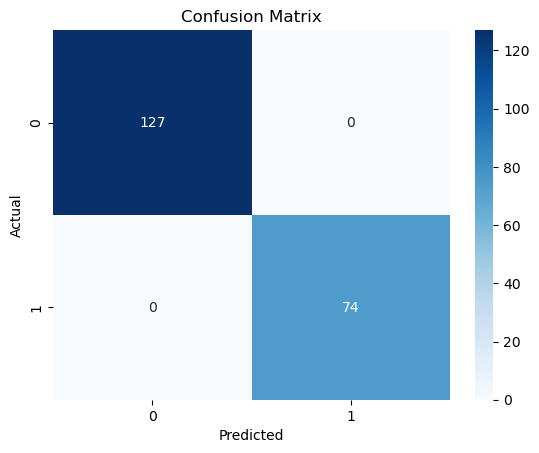


✅ Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       127
           1       1.00      1.00      1.00        74

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201



In [65]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Test setinde tahminler
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 1. Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {acc:.4f}")

# 2. ROC AUC Score
auc = roc_auc_score(y_test, y_prob)
print(f"✅ ROC AUC Score: {auc:.4f}")

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 4. Classification Report
print("\n✅ Classification Report:\n")
print(classification_report(y_test, y_pred))

In [67]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_scaled, y, cv=5, scoring='roc_auc')
print("Cross-validated ROC AUC:", scores)
print("Mean AUC:", scores.mean())

Cross-validated ROC AUC: [1. 1. 1. 1. 1.]
Mean AUC: 1.0


Şu anki model, büyük ihtimalle hedefe doğrudan temas eden sütunlardan besleniyor. O nedenle mükemmel sonuçlar veriyor ama bu genellenebilirlik açısından riskli. Buradan sonra yer alan kodlar deneme amaçlı yazılmıştır.

In [70]:
# Yeni özellik çıkarımı
def clean_features(events, users_df):
    # Trial subscription eventleri varsa 1, yoksa 0
    def binary_feature(event_name):
        return events.groupby("user_id")["event_name"].apply(lambda x: int(event_name in x.values))
    
    features = pd.DataFrame()
    
    # Toplam ödeme
    total_payment = events.groupby("user_id")["amount_usd"].sum().rename("total_payment")
    
    # Etkinlik süresi
    activity = events.groupby("user_id").agg(
        first_event=("created_at", "min"),
        last_event=("created_at", "max")
    )
    activity["active_days"] = (activity["last_event"] - activity["first_event"]).dt.days
    
    # Belli eventler var mı?
    trial_started = binary_feature("trial_started")
    sub_started = binary_feature("subscription_started")
    sub_renewed = events[events["event_name"] == "subscription_renewed"].groupby("user_id").size().rename("subscription_renewed_count")
    
    # churn targetı subscription_cancelled'a göre belirle
    churn = binary_feature("subscription_cancelled").rename("churned")
    
    # Tüm featureları birleştir
    features = pd.concat([total_payment, activity["active_days"], trial_started.rename("trial_started"),
                          sub_started.rename("subscription_started"),
                          sub_renewed, churn], axis=1).fillna(0)
    
    # users bilgisi ile join et
    final_df = features.reset_index().merge(users_df, left_on="user_id", right_on="id")
    final_df = final_df.drop(columns=["id", "name", "created_at"])
    
    # One-hot encoding
    final_df = pd.get_dummies(final_df, columns=["attribution_source", "country"], drop_first=True)
    
    return final_df

# Yeni temiz veri setini hazırla
final_clean_df = clean_features(events_df, users_df)

# Eğitim ve test için X, y ayır
X_clean = final_clean_df.drop(columns=["user_id", "churned"])
y_clean = final_clean_df["churned"]

In [72]:
# Fonksiyonu çağır
final_clean_df = clean_features(events_df, users_df)

# X, y ayır
X_clean = final_clean_df.drop(columns=["user_id", "churned"])
y_clean = final_clean_df["churned"]

# Çıktıya bakalım
print(final_clean_df)
print("\nX_clean:\n", X_clean)
print("\ny_clean:\n", y_clean)


      user_id  total_payment  active_days  trial_started  \
0           1           0.00           17              1   
1           2          35.96          123              1   
2           3          19.96           97              1   
3           4           0.00            9              1   
4           5           0.00            0              0   
...       ...            ...          ...            ...   
997       998           0.00            0              0   
998       999          26.97           74              1   
999      1000           0.00           12              1   
1000     1001           9.99            0              1   
1001     1002           0.00            0              0   

      subscription_started  subscription_renewed_count  churned  \
0                        0                         0.0        0   
1                        1                         3.0        1   
2                        1                         3.0        1   
3          

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Eğitim ve test verisini ayır
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Modeli eğit
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Modelin genel başarısını kontrol et (opsiyonel)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       128
           1       1.00      1.00      1.00        73

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201



In [76]:
# Clark Kent'in verisini çek
clark_kent_features = final_clean_df[final_clean_df["user_id"] == 1002].drop(columns=["user_id", "churned"])

# Olasılığı tahmin et (probability olarak)
clark_kent_proba = model.predict_proba(clark_kent_features)[0][1]  # [0][1] -> churn (1) olasılığı

print(f"Clark Kent için churn olasılığı: %{clark_kent_proba * 100:.2f}")

Clark Kent için churn olasılığı: %0.00
